In [1]:
import pandas as pd
import json
import os
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
file_list = ['육아_이야기.json','요리_레시피.json','건강_운동.json','멘탈관리_심리탐구.json','문화_예술.json',
            '인문학_철학.json','쉽게_읽는_역사.json','우리집_반려동물.json','사랑_이별.json','감성_에세이.json',
            '지구한바퀴_세계여행.json','시사_이슈.json','IT_트렌드.json','취향저격_영화리뷰.json','오늘은_이런책.json',
            '뮤직_인사이드.json','직장인_현실조언.json','스타트업_경험담.json']

In [3]:
dir_name = '~~path~~/json'

def get_file_list(dir_name): # file name들을 가져오는 함수 # 폴더명 인자 # 폴더가 위치한 경로를 인자로
    return os.listdir(dir_name) # 폴더 내 파일명을 리스트 형태로 반환 

file_list = get_file_list(dir_name)

# \n, 공백 제거 후 리스트 형식으로 변환
def pre_keyword(x):
    tmp = []
    for val in x:
        tmp.append(val.replace("\n","").replace(" ",""))
    return tmp

# comment가 없는경우 공백이 아닌 Nan으로 변환
def pre_comment(x):
    if len(x) == 0:
        return None
    else :
        return x
    
#  문자열로 변환
def pre_text(x):
    return str(x)

# datetime형식으로 변환
def pre_datetime(x):
    x = x.split('T')[0]
    x = pd.to_datetime(x,format="%Y-%m-%d")
    return x

all_df = pd.DataFrame(columns=['class','text'])
each_df = {}
class_name = []
for file in file_list:
    with open(~~path~~'+file,encoding='UTF8') as json_file:
        json_data = json.load(json_file)

    class_name.append(file[:-5])
    
    ## json -> DataFrame
    df = pd.DataFrame(json_data['data'],
                  columns=['title','keyword','text','nickname','publish_date','likes','share','comment','url','url_plink'])
    df = df.dropna(subset=['text'])
    df['keyword'] = df['keyword'].apply(pre_keyword)
    df['comment'] = df['comment'].apply(pre_comment)
    df['text'] = df['text'].apply(pre_text)
    df['publish_date'] = df['publish_date'].apply(pre_datetime)
    df.insert(0,"class",file[:-5])

    all_df = pd.concat([all_df,df[['class','title','text','keyword','likes','share','comment','publish_date','url']]])
    each_df[file[:-5]] = df

## 카테고리별 이름에서 0~18로 label encoding
to_categorical = [i for i in range(18)]
class_condition = {}
for a,b in zip(class_name,to_categorical):
    class_condition[a] = b

all_df['ori_class'] = all_df['class']
all_df['class'] = all_df['class'].map(class_condition)
all_df = all_df.reset_index(drop=True)

import re
def pre_text_2(x):
    pa = re.compile("^\\\\xa0|xa") # xla 등 불용어 제거
    pa1 = re.compile(r"'http.*?'") # 전체 url 제거
    pa2 = re.compile(r'\([^)]*\)') # () 사이 문자 
    pa3 = re.compile('[^\w\s]') # 특수문자 삭제
    pa4 = re.compile(r'[^a-zA-Zㄱ-힗]') # 한글,영어만 남김

    x = re.sub(pa,' ',x)
    x = re.sub(pa1,' ',x)
    x = re.sub(pa2,' ',x)
    x = re.sub(pa3, ' ',x)
    x = re.sub(pa4, ' ',x)
    x = x.strip()
    x = " ".join(x.split())
    return x 

all_df['text'] = all_df['text'].apply(pre_text_2)

## 글 길이 500이하 제거
del_list = []
for idx,text in enumerate(all_df['text']):
    if len(text) < 500:
        del_list.append(idx)

all_df = all_df.loc[~all_df.index.isin(del_list), :]

print("전체 문서 : ", len(all_df['text']))
print("중복 문서 : ", len(all_df['text']) - all_df['text'].nunique())

all_df.drop_duplicates(subset=['text'], inplace=True) # 중복문서 제거
print("중복 제거 후 전체 문서 :", len(all_df['text']))

all_df = all_df.reset_index(drop=True) # index 초기화 

class 결측값 :  0
1     17810
10    16016
6     14032
17    12842
15    12796
13    12392
8     10978
16    10445
0      9944
5      9854
12     7903
3      7679
9      7517
2      6397
7      5384
14     5289
11     3925
4      3601
Name: class, dtype: int64


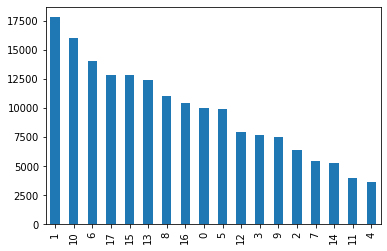

In [6]:
print('class 결측값 : ',all_df['class'].isnull().sum())
print(all_df['class'].value_counts())
all_df['class'].value_counts().plot(kind='bar')

In [7]:
all_df.to_csv("all_df_pText.csv")

In [39]:
all_df = pd.read_csv('all_df_pText.csv',index_col='Unnamed: 0')